### Install and Setup

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchmetrics.classification import Accuracy
from torchvision.models import resnet50, ResNet50_Weights, vgg16, VGG16_Weights
from tqdm import tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
EPOCHS = 5
BATCH_SIZE = 64
LEARNING_RATE = 0.0001
NUM_CLASSES = 10

In [ ]:
def load_data(T, batch_size):
  train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=T)
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

  test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=T)
  test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

  return train_loader, test_loader

In [ ]:
def plot_results(train_losses, test_losses, test_accuracies):
  """
  Plot the train and test losses and accuracy values over a number of epochs.
  """
  fig, ax = plt.subplots(1, 2, figsize=(9, 3))

  ax[0].plot(train_losses, label='Train Loss')
  ax[0].plot(test_losses, label='Test Loss', color='red')
  ax[0].legend()
  ax[1].plot([value for value in test_accuracies], label='Test Accuracy', color='green')

  ax[0].set_title('Train / Test Loss')
  ax[1].set_title('Test Accuracy')

  plt.show()

# Training and Evaluation Functions:
- `train_epoch`
- `eval_model`
- `run_experiment`
- `SimpleCNN`
- `ResNet50Transfer`
- `VGGTransfer`


In the following functions, you are training and evaluating the model for just one epoch (One full pass through the dataset). Complete the `train_epoch` and `eval_model` functions.

In [ ]:
def train_epoch(model, train_loader, optimizer, criterion, device):
  """
  Train the model for one epoch.

  args:
    model: torch.nn.Module, the model to train
    train_loader: torch.utils.data.DataLoader, the dataloader for the training set
    optimizer: torch.optim.Optimizer, the optimizer to use
    criterion: torch.nn.Module, the loss function to use
    device: torch.device

  returns:
    train_loss: float, the average loss over the training set for this epoch
  """
  running_loss = 0.0
  # set the model to training e.g. enable dropouts
  model.train()

  # Iterate through the batch of samples in the train set
  for inputs, targets in tqdm(train_loader):

    # zero the previously calculated gradients
    optimizer.zero_grad()

    # make predictions
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)

    # calculate the loss
    loss = criterion(outputs, targets)

    # calculate the gradient of the loss
    loss.backward()

    # adjust the model parameters based on the gradient
    optimizer.step()

    # keep track of the loss, multiply by the batch size
    running_loss += loss.item() * inputs.size(0)

  # return the average of the loss over all of the batches
  return running_loss / len(train_loader.dataset)

def eval_model(model, test_loader, criterion, acc, device):

  """
  Evaluate the model on the test set.

  args:
    model: torch.nn.Module, the model to evaluate
    test_loader: torch.utils.data.DataLoader, the dataloader for the test set
    criterion: torch.nn.Module, the loss function to use
    acc: torchmetrics.Accuracy, the accuracy metric object
    device: torch.device

  returns:
    test_loss: float, the average loss over the test set
    test_acc: float, the accuracy over the test set
  """

  running_loss = 0.0
  # set the model to eval mode e.g. disable dropouts
  model.eval()

  # reset the calculated accuracy object
  acc.reset()

  # make sure the following does not affect the gradient calculation
  with torch.no_grad():
    # Iterate through the batch of samples in the test set
    for inputs, targets in tqdm(test_loader):
      # make predictions
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)

      # calculate the loss
      loss = criterion(outputs, targets)

      # keep track of the loss, multiply by the batch size
      running_loss += loss.item() * inputs.size(0)

      # update the overall accuracy by including the accuracy of this batch
      acc.update(outputs, targets)

  # return:
    # the average loss over the test set
    # the accuracy over the test set
  return running_loss / len(test_loader.dataset), acc.compute()


In the following function you will use the previous function to train the model over a number of epochs. Complete the `run_experiment` function.

In [ ]:
def run_experiment(model, train_loader, test_loader, optimizer, criterion, device, epochs=10):
  """
  Run the experiment for a given number of epochs.

  args:
    model: torch.nn.Module, the model to train
    train_loader: torch.utils.data.DataLoader, the dataloader for the training set
    test_loader: torch.utils.data.DataLoader, the dataloader for the test set
    optimizer: torch.optim.Optimizer, the optimizer to use
    criterion: torch.nn.Module, the loss function to use
    device: torch.device
    epochs: int, the number of epochs to train for

  returns:
    train_losses: list of floats, the train loss for each epoch
    test_losses: list of floats, the test loss for each epoch
    accuracies: list of floats, the test accuracy for each epoch
  """
  train_losses = []
  test_losses = []
  accuracies = []

  # Initialize the accuracy object
  acc = Accuracy('multiclass', num_classes = NUM_CLASSES).to(device)

  # Interate through the number of epochs
  for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Train the model (using the `train_epoch` function)
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)

    # Keep track of the training loss for this epoch
    train_losses.append(train_loss)

    # Evaluate the model (using the `eval_model` function)
    test_loss, accuracy = eval_model(model, test_loader, criterion, acc, device)

    # Keep track of the testing loss and the testing accuracy for this epoch
    test_losses.append(test_loss)
    # Convert tesnor to cpu and extract, this was done cuz collab was throwing an error
    accuracies.append(accuracy.cpu().item())

    # Print the loss and accuracy values for this epoch
    print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")

  print("Finished training.")

  # return:
    # train_losses: list of floats, the train loss for each epoch
    # test_losses: list of floats, the test loss for each epoch
    # accuracies: list of floats, the test accuracy for each epoch
  return train_losses, test_losses, accuracies

In [ ]:
class SimpleCNN(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()

    # Note I know nn methods will be accept with no named parameters, but wrote some in for clarity and possible error checking
    # Using nn.Sequential to group the layers together

    # Convolution(3x3 kernel) channels: 3 -> 32
    # ReLU
    # Max pooling (2x2)
    self.conv1 = nn.Sequential(nn.Conv2d(3, 32, kernel_size = 3, padding = 1), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2))

    # Convolution(3x3 kernel) channels: 32 -> 64
    # ReLU
    # Max pooling (2x2)
    self.conv2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size = 3, padding = 1), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2))

    # Convolution(3x3 kernel) channels: 64 -> 128
    # ReLU
    # Max pooling (2x2)
    self.conv3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size = 3, padding = 1), nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2))

    # Linear 512 hidden_dim
    # ReLU
    # Linear output -> num_classes
    # After 3 max pooling operations, 32x32 -> 4x4
    self.fc = nn.Sequential(nn.Flatten(), nn.Linear(128*4*4, 512), nn.ReLU(), nn.Linear(512, num_classes))

    pass

  def forward(self, x):
    # All we have to do is pass the input through the layers in order
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.fc(x)
    return x

In [ ]:
class ResNet50Transfer(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()

    # Initialize Resnet 50 with the default weights
    self.resnet = resnet50(weights = ResNet50_Weights.DEFAULT)

    # Freeze the resnet weights
    for param in self.resnet.parameters():
      param.requires_grad = False

    # replace the last fully connected layers with the following:
      # Linear 256 hidden_dim
      # ReLU
      # Linear output -> num_classes

      # ResNet50 always has 2048 features at the end of the backbone
      in_features = 2048

      self.resnet.fc = nn.Sequential(nn.Linear(in_features, 256), nn.ReLU(), nn.Linear(256, num_classes))


  def forward(self, x):
    return self.resnet(x)

In [ ]:
class VGGTransfer(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()

    # Initialize VGG16 with the default weights
    self.vgg = vgg16(weights = VGG16_Weights.DEFAULT)

    # Freeze the feature weights
    for param in self.vgg.features.parameters():
      param.requires_grad = False

    # Replace the classifier with the following:
    # Linear 256 hidden_dim
    # ReLU
    # Linear output -> num_classes
    # VGG16 features output is 512x7x7
    self.vgg.classifier = nn.Sequential(nn.Flatten(), nn.Linear(512 * 7 * 7, 256), nn.ReLU(), nn.Linear(256, num_classes))

  def forward(self, x):
    x = self.vgg.features(x)
    x = self.vgg.classifier(x)
    return x

# Experiment 1: Custom CNN (SimpleCNN) on CIFAR-10
- Train and evaluate the `SimpleCNN` model on the CIFAR-10 dataset (for 5 epochs minimum).
- Plot the train and test loss, as well as the test accuracy.
- Analyze and report the results. Provide reasoning for your analysis.

In [ ]:
T = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader, test_loader = load_data(T, BATCH_SIZE)
simple_cnn = SimpleCNN(NUM_CLASSES).to(device)
optimizer = torch.optim.Adam(simple_cnn.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

train_losses, test_losses, accuracies = run_experiment(simple_cnn, train_loader, test_loader, optimizer, criterion, device, EPOCHS)

Epoch 1/5


100%|██████████| 157/157 [00:02<00:00, 56.89it/s]


Train Loss: 1.6788, Test Loss: 1.4262, Test Accuracy: 0.4860
Epoch 2/5


100%|██████████| 157/157 [00:03<00:00, 42.07it/s]


Train Loss: 1.3720, Test Loss: 1.2908, Test Accuracy: 0.5384
Epoch 3/5


100%|██████████| 157/157 [00:02<00:00, 55.16it/s]


Train Loss: 1.2617, Test Loss: 1.2188, Test Accuracy: 0.5666
Epoch 4/5


100%|██████████| 157/157 [00:02<00:00, 56.18it/s]


Train Loss: 1.1739, Test Loss: 1.1363, Test Accuracy: 0.5974
Epoch 5/5


100%|██████████| 157/157 [00:03<00:00, 43.83it/s]

Train Loss: 1.0980, Test Loss: 1.1123, Test Accuracy: 0.6079
Finished training.


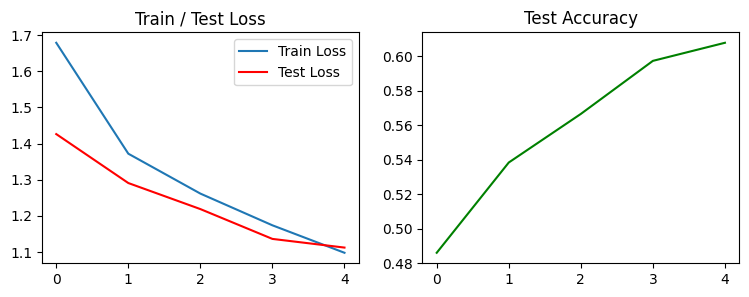

In [ ]:
plot_results(train_losses, test_losses, accuracies)

# Analysis of SimpleCNN Results

Looking at the graphs, I can see our SimpleCNN model gradually improved on the CIFAR-10 dataset over the 5 training epochs.

## Loss Trends
- Training loss (blue) starts around 1.7 and decreases steadily
- Test loss (red) begins at a lower value of about 1.45
- Both curves converge to around 1.1 by epoch 5, showing the model isn't overfitting

## Accuracy Progress
- Test accuracy climbs from about 48.5% to 60%
- The curve is still going up at epoch 5, so more training could help
- 60% accuracy is decent for such a simple network on CIFAR-10's 10 classes

## What This Tells Us
The model is learning meaningful features with its convolutional layers, as we see in lecture 14. Each layer is extracting more complex pattern, from simple edges in early layers to more complex shapes in later ones. The max pooling layers help with translation invariance while reducing dimensionality.

The fact that training and test performance are closely aligned suggests the model is generalizing well rather than overfitting. Since accuracy is still improving after five epochs, it’s likely that training for longer or using a deeper network like the transfer learning models we’ll explore next could push performance even further.

# Experiment 2: Transfer Learning with ResNet50
- Train and evaluate the `ResNet50_Weights` model on the CIFAR-10 dataset (for 5 epochs minimum).
- Plot the train and test loss, as well as the test accuracy.
- Analyze and report the results. Provide reasoning for your analysis. Make comparisons to the previous experiments when appropriate.

In [ ]:
T = ResNet50_Weights.DEFAULT.transforms()
train_loader, test_loader = load_data(T, BATCH_SIZE)

resnet_transfer = ResNet50Transfer(NUM_CLASSES).to(device)
optimizer = torch.optim.Adam(resnet_transfer.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

train_losses, test_losses, accuracies = run_experiment(resnet_transfer, train_loader, test_loader, optimizer, criterion, device, EPOCHS)

Epoch 1/5


100%|██████████| 157/157 [00:51<00:00,  3.07it/s]


Train Loss: 1.0428, Test Loss: 0.7095, Test Accuracy: 0.7697
Epoch 2/5


100%|██████████| 157/157 [00:52<00:00,  3.01it/s]


Train Loss: 0.6688, Test Loss: 0.6247, Test Accuracy: 0.7872
Epoch 3/5


100%|██████████| 157/157 [00:52<00:00,  2.99it/s]


Train Loss: 0.6060, Test Loss: 0.5958, Test Accuracy: 0.7956
Epoch 4/5


100%|██████████| 157/157 [00:52<00:00,  2.96it/s]


Train Loss: 0.5675, Test Loss: 0.5682, Test Accuracy: 0.8032
Epoch 5/5


100%|██████████| 157/157 [00:51<00:00,  3.07it/s]

Train Loss: 0.5405, Test Loss: 0.5643, Test Accuracy: 0.8070
Finished training.


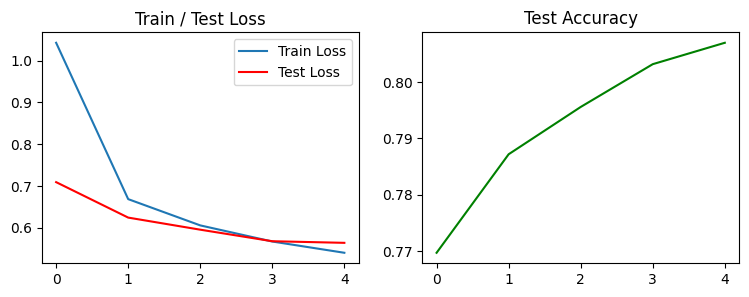

In [ ]:
plot_results(train_losses, test_losses, accuracies)

# Analysis of ResNet50Transfer Results

Looking at the graphs, I can see the ResNet50 transfer learning model performs much better than our SimpleCNN on the CIFAR-10 dataset.

## Loss Trends
- Training loss starts around 1.05 and drops quickly, while test loss begins at about 0.72
- Both curves steadily decrease and nearly meet around 0.55-0.57 by epoch 4
- The loss curves flatten out faster than what we saw with SimpleCNN

## Accuracy Progress
- Test accuracy starts impressively high at about 77% (compared to SimpleCNN's 48.5%)
- By epoch 5, accuracy reaches around 81%, way better than SimpleCNN's 60%
- The curve is still going up, suggesting more training could help even more

## What This Tells Us
The dramatic improvement shows the power of transfer learning we studied in lecture 17. By using the pre-trained ResNet50 backbone (trained on ImageNet) and only training a new classifier head, we're leveraging all the feature extraction capabilities the model already learned.

The high starting accuracy (77%) proves how effective transfer learning is, the model already "knows" how to identify basic and complex patterns from its previous training. This explains the huge jump in performance compared to our simple CNN, even though we're only training the final layers.

#  Experiment 3: Transfer Learning with VGG16
- Train and evaluate the `VGGTransfer` model on the CIFAR-10 dataset (for 5 epochs minimum).
- Plot the train and test loss, as well as the test accuracy.
- Analyze and report the results. Provide reasoning for your analysis. Make comparisons to the previous experiments when appropriate.

In [ ]:
T = VGG16_Weights.DEFAULT.transforms()
train_loader, test_loader = load_data(T, BATCH_SIZE)

vgg_transfer = VGGTransfer(NUM_CLASSES).to(device)
optimizer = torch.optim.Adam(vgg_transfer.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

train_losses, test_losses, accuracies = run_experiment(vgg_transfer, train_loader, test_loader, optimizer, criterion, device, EPOCHS)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 83.0MB/s]


Epoch 1/5


100%|██████████| 157/157 [01:13<00:00,  2.13it/s]


Train Loss: 0.4802, Test Loss: 0.4119, Test Accuracy: 0.8586
Epoch 2/5


100%|██████████| 157/157 [01:12<00:00,  2.17it/s]


Train Loss: 0.2065, Test Loss: 0.4174, Test Accuracy: 0.8591
Epoch 3/5


100%|██████████| 157/157 [01:12<00:00,  2.16it/s]


Train Loss: 0.1043, Test Loss: 0.4172, Test Accuracy: 0.8653
Epoch 4/5


100%|██████████| 157/157 [01:12<00:00,  2.16it/s]


Train Loss: 0.0503, Test Loss: 0.4650, Test Accuracy: 0.8625
Epoch 5/5


100%|██████████| 157/157 [01:12<00:00,  2.17it/s]

Train Loss: 0.0235, Test Loss: 0.4950, Test Accuracy: 0.8633
Finished training.


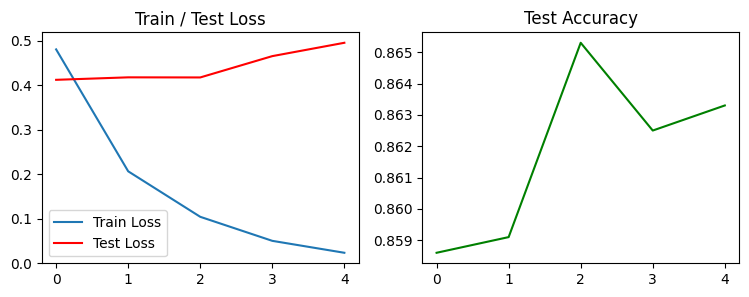

In [ ]:
plot_results(train_losses, test_losses, accuracies)

# Analysis of VGGTransfer Results

Looking at the graphs, I can see the VGG16 transfer learning model behaves quite differently from our previous models on the CIFAR-10 dataset.

## Loss Trends
- Training loss (blue) starts around 0.48 and plummets dramatically to nearly 0 by epoch 4
- Test loss (red) starts at about 0.45, remains flat, then unexpectedly increases to around 0.5
- The growing gap between train and test loss is a classic sign of overfitting

## Accuracy Progress
- Test accuracy starts impressively high at about 85.85% (much higher than both previous models)
- Peaks at epoch 2 with approximately 86.5% accuracy
- Then surprisingly decreases and fluctuates around 86.3% by epoch 5

## What This Tells Us
The VGG16 model demonstrates both the benefits and pitfalls of transfer learning that we learned in lectures 17 and 18. While it achieves the highest overall accuracy of our three models, it shows clear signs of overfitting - the model is essentially memorizing the training data (near-zero training loss) rather than learning generalizable features.

Compared to ResNet50 (81% accuracy) and SimpleCNN (60% accuracy), VGG16 delivers superior classification performance at around 86.5%. However, the decreasing accuracy after epoch 2 suggests we should implement early stopping or stronger regularization techniques. This behavior illustrates why monitoring validation metrics during training is crucial - more training doesn't always mean better performance.